In [ ]:
!git clone https://bitbucket.org/jadslim/german-traffic-signs

fatal: destination path 'german-traffic-signs' already exists and is not an empty directory.


In [ ]:
!ls german-traffic-signs

signnames.csv  test.p  train.p	valid.p


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import keras
import pickle
import pandas as pd
import random
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.layers import Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
np.random.seed(0)

In [ ]:
with open('german-traffic-signs/train.p', 'rb') as f:
  train_data = pickle.load(f)

with open('german-traffic-signs/valid.p', 'rb') as f:
  valid_data = pickle.load(f)

with open('german-traffic-signs/test.p', 'rb') as f:
  test_data = pickle.load(f)

X_train, y_train = train_data['features'], train_data['labels']
X_valid, y_valid = valid_data['features'], valid_data['labels']
X_test, y_test = test_data['features'], test_data['labels']

In [ ]:
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

(34799, 32, 32, 3)
(4410, 32, 32, 3)
(12630, 32, 32, 3)


In [ ]:
assert(X_train.shape[0] == y_train.shape[0]), 'The number of images is not equal to the number of labels!'
assert(X_valid.shape[0] == y_valid.shape[0]), 'The number of images is not equal to the number of labels!'
assert(X_test.shape[0] == y_test.shape[0]), 'The number of images is not equal to the number of labels!'
assert(X_train.shape[1:] == (32, 32, 3)), 'The dimensions of the images are not 32 x 32 x 3!'
assert(X_valid.shape[1:] == (32, 32, 3)), 'The dimensions of the images are not 32 x 32 x 3!'
assert(X_test.shape[1:] == (32, 32, 3)), 'The dimensions of the images are not 32 x 32 x 3!'

[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


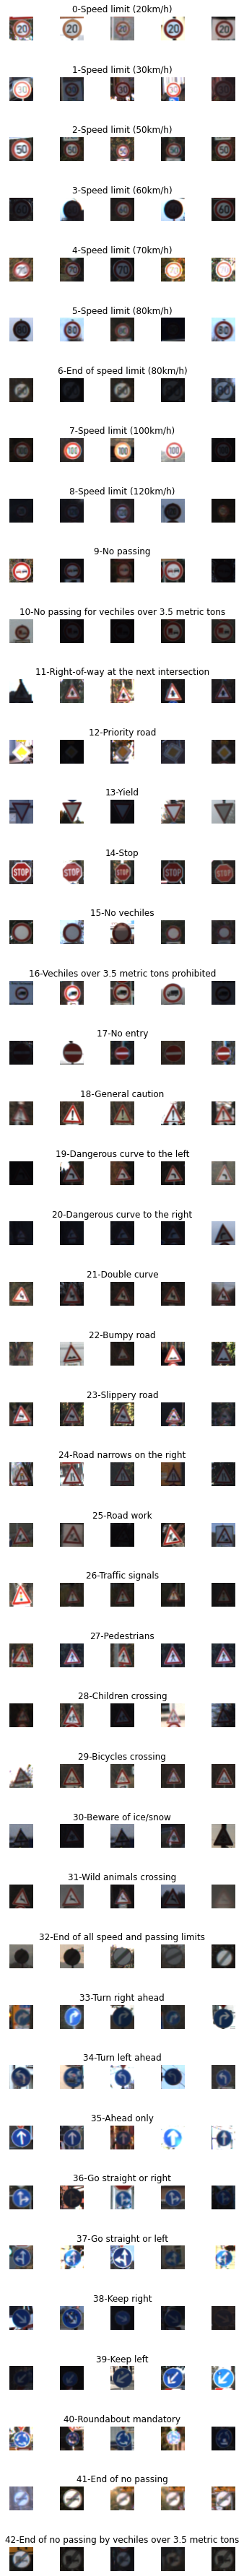

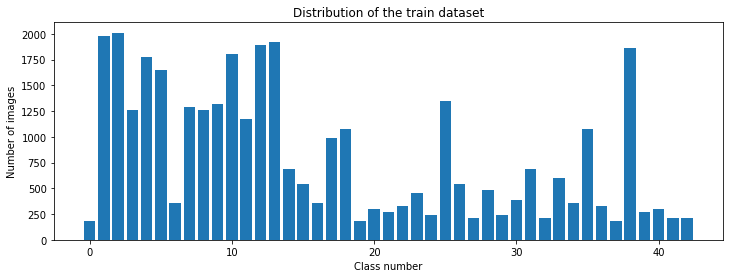

In [ ]:
data = pd.read_csv('german-traffic-signs/signnames.csv')

num_of_samples = []
 
cols = 5
num_classes = 43
 
fig, axs = plt.subplots(nrows=num_classes, ncols = cols, figsize=(5, 50))
fig.tight_layout()
for i in range(cols):
    for j, row in data.iterrows():
        x_selected = X_train[y_train == j]
        axs[j][i].imshow(x_selected[random.randint(0,(len(x_selected) - 1)), :, :], cmap=plt.get_cmap('gray'))
        axs[j][i].axis("off")
        if i == 2:
            axs[j][i].set_title(str(j) + '-' + row['SignName'])
            num_of_samples.append(len(x_selected))
print(num_of_samples)
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the train dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.show()


(32, 32, 3)
36


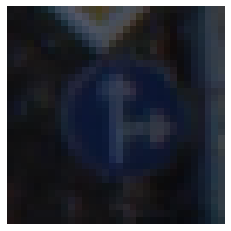

In [ ]:
import cv2 

plt.imshow(X_train[1000])
plt.axis('off')
print(X_train[1000].shape)
print(y_train[1000])

(32, 32)


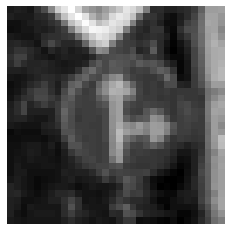

In [ ]:
def grayscale(image):
  image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  return image

image = grayscale(X_train[1000])
plt.imshow(image, cmap=plt.get_cmap('gray'))
plt.axis('off')
print(image.shape)


(32, 32)


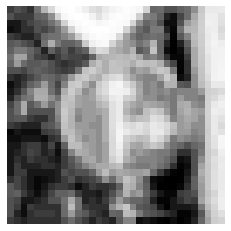

In [ ]:
def equalize(image):
  image = cv2.equalizeHist(image)
  return image

image = equalize(image)
plt.imshow(image, cmap=plt.get_cmap('gray'))
plt.axis('off')
print(image.shape)


In [ ]:
def preprocessing(image):
  image = grayscale(image)
  image = equalize(image)
  image = image/255
  return image

X_train = np.array(list(map(preprocessing, X_train)))
X_valid = np.array(list(map(preprocessing, X_valid)))
X_test = np.array(list(map(preprocessing, X_test)))

(34799, 32, 32)


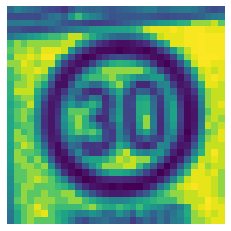

In [ ]:
plt.imshow(X_train[random.randint(0, len(X_train) - 1)])
plt.axis('off')
print(X_train.shape)

In [ ]:
X_train = X_train.reshape(34799, 32, 32, 1)
X_valid = X_valid.reshape(4410, 32, 32, 1)
X_test = X_test.reshape(12630, 32, 32, 1)

(20, 32, 32, 1)


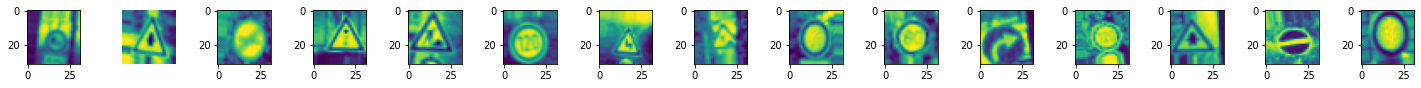

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

data_gen = ImageDataGenerator(width_shift_range=0.1,
                            height_shift_range=0.1,
                            zoom_range=0.2,
                            shear_range=0.1,
                            rotation_range=10.)

data_gen.fit(X_train)

batches = data_gen.flow(X_train, y_train, batch_size=20)
X_batch, y_batch = next(batches)

fig, axs = plt.subplots(1, 15, figsize=(20, 5))
fig.tight_layout()

for i in range(15):
  axs[i].imshow(X_batch[i].reshape(32, 32))
  axs[1].axis('off')

print(X_batch.shape)

In [ ]:
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

(34799, 32, 32, 1)
(4410, 32, 32, 1)
(12630, 32, 32, 1)


In [ ]:
y_train = to_categorical(y_train, 43)
y_valid = to_categorical(y_valid, 43)
y_test = to_categorical(y_test, 43)


In [ ]:
def modified_model():
  model = Sequential()
  model.add(Conv2D(60, (5, 5), input_shape=(32, 32, 1), activation='relu'))
  model.add(Conv2D(60, (5, 5), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  
  model.add(Conv2D(30, (3, 3), activation='relu'))
  model.add(Conv2D(30, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  
  model.add(Flatten())
  model.add(Dense(500, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(43, activation='softmax'))

  #Compile Model
  model.compile(Adam(lr = 0.001), loss='categorical_crossentropy', metrics=['accuracy'])  
  return model

In [ ]:
model = modified_model()
print(model.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 28, 28, 60)        1560      
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 24, 24, 60)        90060     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 12, 12, 60)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 10, 10, 30)        16230     
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 8, 8, 30)          8130      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 4, 4, 30)          0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 480)              

In [ ]:
history = model.fit_generator(data_gen.flow(X_train, y_train, batch_size=50), 
                              steps_per_epoch=X_train.shape[0]/50, 
                              epochs=15, 
                              validation_data=(X_valid, y_valid),
                              shuffle = 1)

Epoch 1/15
696/695 [==============================] - 12s 17ms/step - loss: 1.8664 - accuracy: 0.4706 - val_loss: 0.3311 - val_accuracy: 0.9032
Epoch 2/15
696/695 [==============================] - 12s 17ms/step - loss: 0.5564 - accuracy: 0.8303 - val_loss: 0.0990 - val_accuracy: 0.9680
Epoch 3/15
696/695 [==============================] - 12s 17ms/step - loss: 0.3360 - accuracy: 0.8955 - val_loss: 0.0979 - val_accuracy: 0.9664
Epoch 4/15
696/695 [==============================] - 12s 17ms/step - loss: 0.2535 - accuracy: 0.9214 - val_loss: 0.0687 - val_accuracy: 0.9764
Epoch 5/15
696/695 [==============================] - 12s 17ms/step - loss: 0.2111 - accuracy: 0.9344 - val_loss: 0.0506 - val_accuracy: 0.9841
Epoch 6/15
696/695 [==============================] - 12s 17ms/step - loss: 0.1828 - accuracy: 0.9416 - val_loss: 0.0450 - val_accuracy: 0.9866
Epoch 7/15
696/695 [==============================] - 12s 17ms/step - loss: 0.1633 - accuracy: 0.9499 - val_loss: 0.0512 - val_accuracy:

Text(0.5, 0, 'epoch')

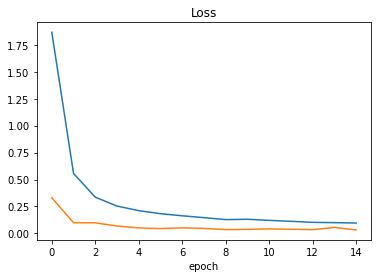

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

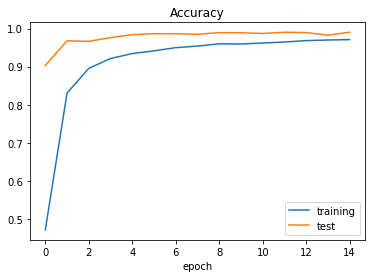

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training','test'])
plt.title('Accuracy')
plt.xlabel('epoch')

In [ ]:
score = model.evaluate(X_test, y_test, verbose=0)

print('Test Score:', score[0])
print('Test Accuracy:', score[1])

Test Score: 0.12569227814674377
Test Accuracy: 0.969437837600708


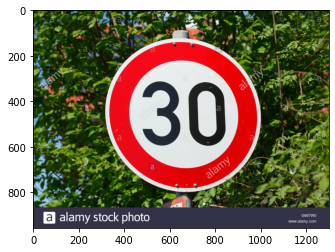

In [ ]:
import requests
from PIL import Image
url = 'https://c8.alamy.com/comp/G667W0/road-sign-speed-limit-30-kmh-zone-passau-bavaria-germany-G667W0.jpg'
r = requests.get(url, stream=True)
image = Image.open(r.raw)
plt.imshow(image, cmap=plt.get_cmap('gray'))

(32, 32)


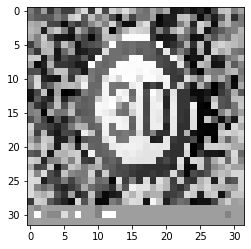

In [ ]:
image = np.asarray(image)
image = cv2.resize(image, (32, 32))
image = preprocessing(image)
plt.imshow(image, cmap = plt.get_cmap('gray'))
print(image.shape)

In [ ]:
image = image.reshape(1, 32, 32, 1)

In [ ]:
print("predicted sign: "+ str(model.predict_classes(image)))

predicted sign: [1]
